# < K리그 패스 좌표 예측 - 초기 데이터 탐색 > 

- **목표**: 데이터 구조 파악 및 기본 통계 확인
- **날짜**: 2025-12-11
- **작성자**: polarsnow09

## 1. 환경설정 

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path

In [3]:
# 한글 폰트 설정 (Windows)
plt.rc('font', family='Malgun Gothic')
plt.rc('axes', unicode_minus=False)

# 경로 설정
DATA_DIR = Path('../data/raw')
PROCESSED_DIR = Path('../data/processed')

In [4]:
# 데이터 파일 확인 및 크기 출력
print("📂 사용 가능한 데이터 파일:")
for file in DATA_DIR.glob('*.csv'):
    size = file.stat().st_size / 1024 / 1024  # MB
    print(f"  - {file.name}: {size:.2f} MB")

📂 사용 가능한 데이터 파일:
  - match_info.csv: 0.03 MB
  - sample_submission.csv: 0.05 MB
  - test.csv: 0.10 MB
  - train.csv: 41.54 MB


## 2. Data loading

In [5]:
train = pd.read_csv(DATA_DIR / 'train.csv')
test = pd.read_csv(DATA_DIR / 'test.csv')
match_info = pd.read_csv(DATA_DIR / 'match_info.csv')
sample_submission = pd.read_csv(DATA_DIR / 'sample_submission.csv')

print("✅ 데이터 로딩 완료")
print(f"  - Train: {train.shape}")
print(f"  - Test: {test.shape}")
print(f"  - Match Info: {match_info.shape}")

✅ 데이터 로딩 완료
  - Train: (356721, 15)
  - Test: (2414, 3)
  - Match Info: (228, 17)


## 3. 기본 정보 확인

In [6]:
# Train 데이터 구조
print("🔍 Train 데이터 미리보기:")
display(train.head())
print("\n🎇컬럼 정보:")
display(train.info())

🔍 Train 데이터 미리보기:


,game_id,period_id,episode_id,time_seconds,team_id,player_id,action_id,type_name,result_name,start_x,start_y,end_x,end_y,is_home,game_episode
0,126283,1,1,0.667,2354,344559,0,Pass,Successful,52.418205,33.485444,31.322445,38.274752,True,126283_1
1,126283,1,1,3.667,2354,250036,2,Pass,Successful,32.013240,38.100808,37.371285,30.632980,True,126283_1
2,126283,1,1,4.968,2354,500145,4,Carry,NaN,37.371285,30.632980,38.391570,24.613144,True,126283_1
3,126283,1,1,8.200,2354,500145,5,Pass,Successful,38.391570,24.613144,34.573350,5.545468,True,126283_1
4,126283,1,1,11.633,2354,142106,7,Pass,Successful,34.578705,6.058256,21.274470,18.437112,True,126283_1



🎇컬럼 정보:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 356721 entries, 0 to 356720
Data columns (total 15 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   game_id       356721 non-null  int64  
 1   period_id     356721 non-null  int64  
 2   episode_id    356721 non-null  int64  
 3   time_seconds  356721 non-null  float64
 4   team_id       356721 non-null  int64  
 5   player_id     356721 non-null  int64  
 6   action_id     356721 non-null  int64  
 7   type_name     356721 non-null  object 
 8   result_name   216467 non-null  object 
 9   start_x       356721 non-null  float64
 10  start_y       356721 non-null  float64
 11  end_x         356721 non-null  float64
 12  end_y         356721 non-null  float64
 13  is_home       356721 non-null  bool   
 14  game_episode  356721 non-null  object 
dtypes: bool(1), float64(5), int64(6), object(3)
memory usage: 38.4+ MB


None

In [7]:
# 결측치 확인
print("❓ 결측치 현황:")
missing = train.isnull().sum()
missing_pct = 100 * missing / len(train)
missing_df = pd.DataFrame({
    '결측치 개수': missing,
    '비율(%)': missing_pct
})
display(missing_df[missing_df['결측치 개수'] > 0])

❓ 결측치 현황:


,결측치 개수,비율(%)
result_name,140254,39.317562


## 4. 타겟 변수 확인

In [8]:
# 예측 대상 확인 (sample_submission 구조 체크)
print("🎯 제출 형식:")
display(sample_submission.head())

🎯 제출 형식:


,game_episode,end_x,end_y
0,153363_1,50.0,50.0
1,153363_2,50.0,50.0
2,153363_6,50.0,50.0
3,153363_7,50.0,50.0
4,153363_8,50.0,50.0


## 5. 좌표 데이터 기본 탐색

In [9]:
# 좌표 범위 확인
print("📍 좌표 범위:")
print(f"start_x: {train['start_x'].min():.2f} ~ {train['start_x'].max():.2f}")
print(f"start_y: {train['start_y'].min():.2f} ~ {train['start_y'].max():.2f}")
print(f"end_x: {train['end_x'].min():.2f} ~ {train['end_x'].max():.2f}")
print(f"end_y: {train['end_y'].min():.2f} ~ {train['end_y'].max():.2f}")

📍 좌표 범위:
start_x: 0.00 ~ 105.00
start_y: 0.00 ~ 68.00
end_x: 0.00 ~ 105.00
end_y: 0.00 ~ 68.00


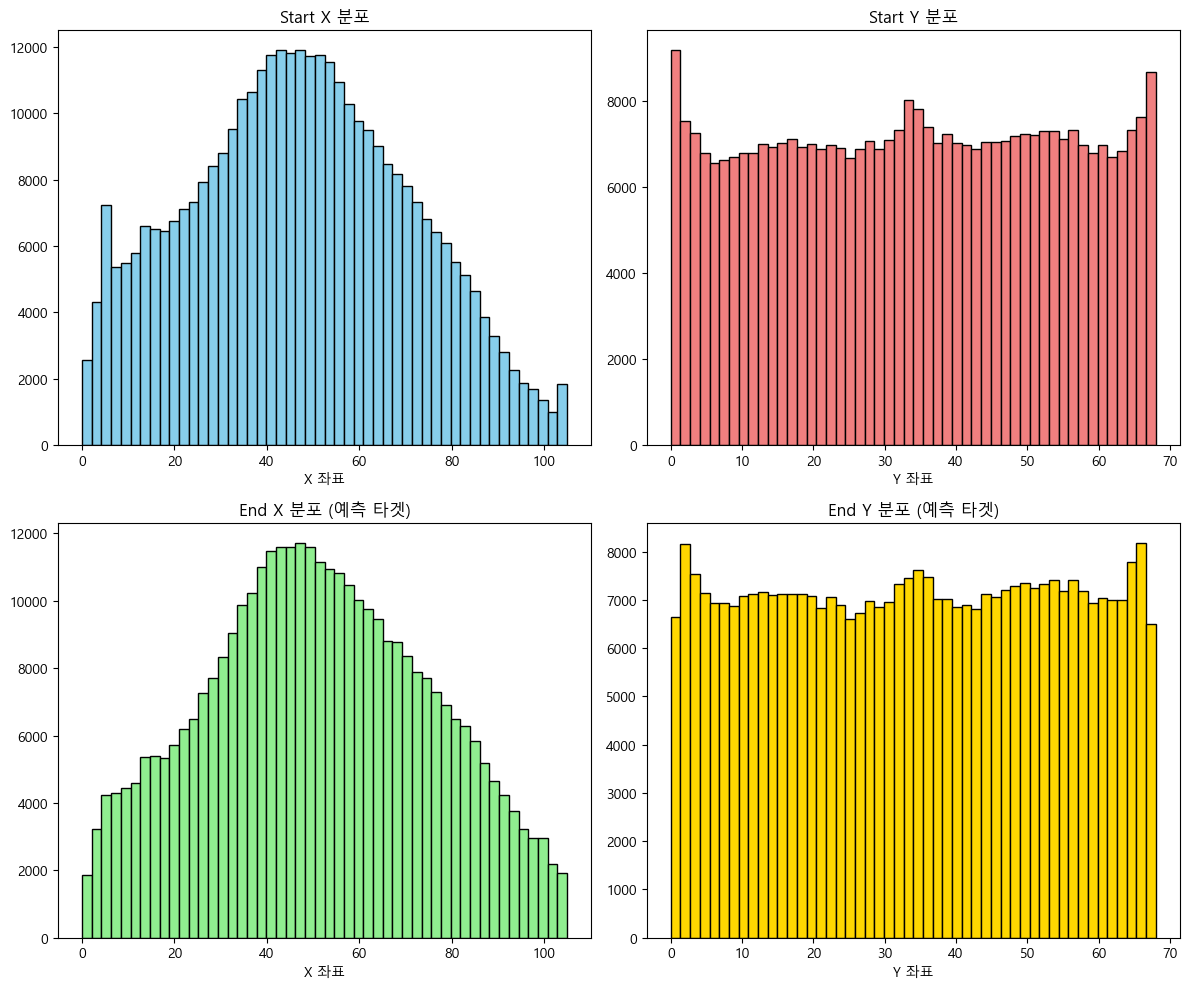

In [10]:
# 좌표 분포 시각화
fig, axes = plt.subplots(2, 2, figsize=(12, 10))

# Start X
axes[0, 0].hist(train['start_x'].dropna(), bins=50, color='skyblue', edgecolor='black')
axes[0, 0].set_title('Start X 분포')
axes[0, 0].set_xlabel('X 좌표')

# Start Y
axes[0, 1].hist(train['start_y'].dropna(), bins=50, color='lightcoral', edgecolor='black')
axes[0, 1].set_title('Start Y 분포')
axes[0, 1].set_xlabel('Y 좌표')

# End X
axes[1, 0].hist(train['end_x'].dropna(), bins=50, color='lightgreen', edgecolor='black')
axes[1, 0].set_title('End X 분포 (예측 타겟)')
axes[1, 0].set_xlabel('X 좌표')

# End Y
axes[1, 1].hist(train['end_y'].dropna(), bins=50, color='gold', edgecolor='black')
axes[1, 1].set_title('End Y 분포 (예측 타겟)')
axes[1, 1].set_xlabel('Y 좌표')

plt.tight_layout()
plt.savefig('../reports/figures/coordinate_distribution.png', dpi=150, bbox_inches='tight')
plt.show()

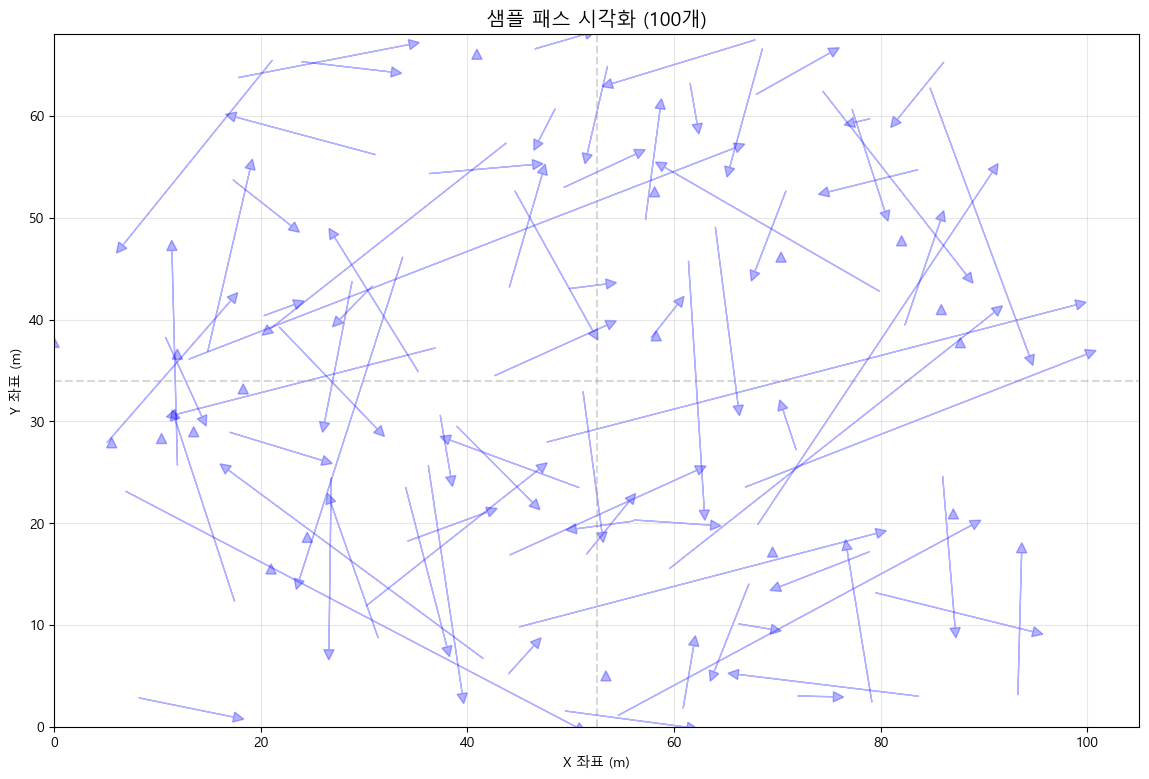

In [11]:
# 패스 시각화 (샘플 100개)
plt.figure(figsize=(14, 9))

# 경기장 그리기 (추정: 105m x 68m)
plt.xlim(0, 105)
plt.ylim(0, 68)
plt.axhline(y=34, color='gray', linestyle='--', alpha=0.3, label='중앙선')
plt.axvline(x=52.5, color='gray', linestyle='--', alpha=0.3)

# 랜덤 샘플 100개 패스 그리기
sample_passes = train.dropna(subset=['start_x', 'start_y', 'end_x', 'end_y']).sample(100)

for idx, row in sample_passes.iterrows():
    plt.arrow(row['start_x'], row['start_y'], 
              row['end_x'] - row['start_x'], 
              row['end_y'] - row['start_y'],
              head_width=1, head_length=1, fc='blue', ec='blue', alpha=0.3)

plt.title('샘플 패스 시각화 (100개)', fontsize=14)
plt.xlabel('X 좌표 (m)')
plt.ylabel('Y 좌표 (m)')
plt.grid(True, alpha=0.3)
plt.savefig('../reports/figures/pass_visualization_sample.png', dpi=150, bbox_inches='tight')
plt.show()

## 6. 범주형 변수 탐색

⚽ 액션 타입 분포:
type_name
Pass                178582
Carry                82046
Recovery             27352
Interception         11088
Duel                  8734
Tackle                8138
Throw-In              6801
Clearance             6563
Intervention          6038
Block                 3983
Pass_Freekick         3824
Cross                 3589
Goal Kick             2713
Error                 1647
Shot                  1413
Pass_Corner           1137
Catch                 1019
Take-On                987
Aerial Clearance       478
Parry                  373
Hit                    130
Shot_Freekick           43
Foul                    26
Deflection              14
Penalty Kick             2
Handball_Foul            1
Name: count, dtype: int64


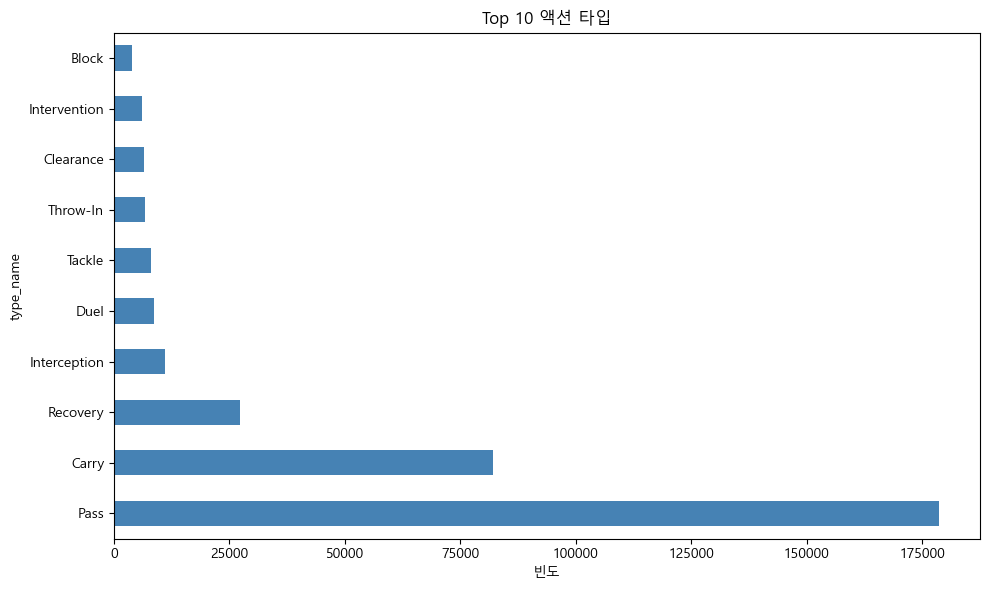

In [12]:
# type_name 분포 (패스 종류)
print("⚽ 액션 타입 분포:")
print(train['type_name'].value_counts())

plt.figure(figsize=(10, 6))
train['type_name'].value_counts().head(10).plot(kind='barh', color='steelblue')
plt.title('Top 10 액션 타입')
plt.xlabel('빈도')
plt.tight_layout()
plt.savefig('../reports/figures/action_type_distribution.png', dpi=150, bbox_inches='tight')
plt.show()

In [13]:
# result_name 분포 (성공/실패)
print("\n✅ 액션 결과 분포:")
print(train['result_name'].value_counts())


✅ 액션 결과 분포:
result_name
Successful          178537
Unsuccessful         36446
On Target              692
Blocked                635
Low Quality Shot        71
Off Target              48
Yellow_Card             26
Keeper Rush-Out         12
Name: count, dtype: int64


In [14]:
# game_episode 확인 (test 데이터와 매칭)
print(f"\n🎮 총 에피소드 수: {train['game_episode'].nunique()}")
print(f"게임 수: {train['game_id'].nunique()}")
print(f"평균 에피소드당 액션: {len(train) / train['game_episode'].nunique():.1f}")


🎮 총 에피소드 수: 15435
게임 수: 198
평균 에피소드당 액션: 23.1


In [15]:
print("\n🔍 episode 구조 확인:")
sample_episode = train[train['game_episode'] == train['game_episode'].iloc[0]]
print(f"샘플 에피소드 길이: {len(sample_episode)}")
print(sample_episode[['time_seconds', 'type_name', 'start_x', 'end_x']].head(10))


🔍 episode 구조 확인:
샘플 에피소드 길이: 49
   time_seconds type_name    start_x      end_x
0         0.667      Pass  52.418205  31.322445
1         3.667      Pass  32.013240  37.371285
2         4.968     Carry  37.371285  38.391570
3         8.200      Pass  38.391570  34.573350
4        11.633      Pass  34.578705  21.274470
5        13.201     Carry  21.274470  28.862295
6        18.900      Pass  28.862295  26.569410
7        19.968     Carry  26.569410  35.039130
8        25.933      Pass  35.039130  33.001500
9        29.767      Pass  35.220780  35.104335


## 7. 액션 타입 상세 분석

In [16]:
# type_name과 result_name 조합
print("⚽ 액션 타입 × 결과:")
action_result = pd.crosstab(train['type_name'], train['result_name'])
print(action_result.head(10))

⚽ 액션 타입 × 결과:
result_name       Blocked  Keeper Rush-Out  Low Quality Shot  Off Target  \
type_name                                                                  
Aerial Clearance        0                0                 0           0   
Cross                   0                0                 0           0   
Duel                    0                0                 0           0   
Foul                    0                0                 0           0   
Goal Kick               0                0                 0           0   
Pass                    0                0                 0           0   
Pass_Corner             0                0                 0           0   
Pass_Freekick           0                0                 0           0   
Penalty Kick            0                0                 0           1   
Shot                  617               12                71          47   

result_name       On Target  Successful  Unsuccessful  Yellow_Card  
type

In [17]:
# Episode 구조 샘플 확인
print("\n🎮 샘플 Episode 분석:")
sample_episode = train[train['game_episode'] == train['game_episode'].iloc[0]]
print(f"에피소드 ID: {sample_episode['game_episode'].iloc[0]}")
print(f"액션 수: {len(sample_episode)}")
print(f"시간 범위: {sample_episode['time_seconds'].min():.1f} ~ {sample_episode['time_seconds'].max():.1f}초")
print("\n에피소드 내용:")
print(sample_episode[['time_seconds', 'type_name', 'result_name', 'start_x', 'start_y', 'end_x', 'end_y']].to_string())


🎮 샘플 Episode 분석:
에피소드 ID: 126283_1
액션 수: 49
시간 범위: 0.7 ~ 124.4초

에피소드 내용:
    time_seconds     type_name   result_name     start_x    start_y       end_x      end_y
0         0.6670          Pass    Successful   52.418205  33.485444   31.322445  38.274752
1         3.6670          Pass    Successful   32.013240  38.100808   37.371285  30.632980
2         4.9680         Carry           NaN   37.371285  30.632980   38.391570  24.613144
3         8.2000          Pass    Successful   38.391570  24.613144   34.573350   5.545468
4        11.6330          Pass    Successful   34.578705   6.058256   21.274470  18.437112
5        13.2010         Carry           NaN   21.274470  18.437112   28.862295  24.320336
6        18.9000          Pass    Successful   28.862295  24.320336   26.569410  35.190204
7        19.9680         Carry           NaN   26.569410  35.190204   35.039130  34.624580
8        25.9330          Pass    Successful   35.039130  34.624580   33.001500  18.885028
9        29.767

## 8. Episode 마지막 액션 분석

In [18]:
# 각 Episode의 마지막 액션 확인
print("🏁 Episode 마지막 액션 타입:")
last_actions = train.groupby('game_episode').last()
print(last_actions['type_name'].value_counts())

print("\n🏁 Episode 마지막 액션의 result_name:")
print(last_actions['result_name'].value_counts())

🏁 Episode 마지막 액션 타입:
type_name
Pass    15435
Name: count, dtype: int64

🏁 Episode 마지막 액션의 result_name:
result_name
Successful      8634
Unsuccessful    6801
Name: count, dtype: int64


In [19]:
# Test 데이터와 비교
print("\n📊 Test 데이터 구조:")
test_data = pd.read_csv(DATA_DIR / 'test.csv')
print(f"Test 크기: {test_data.shape}")
print(f"Test 컬럼: {test_data.columns.tolist()}")
print("\nTest 샘플:")
display(test_data.head())


📊 Test 데이터 구조:
Test 크기: (2414, 3)
Test 컬럼: ['game_id', 'game_episode', 'path']

Test 샘플:


,game_id,game_episode,path
0,153363,153363_1,./test/153363/153363_1.csv
1,153363,153363_2,./test/153363/153363_2.csv
2,153363,153363_6,./test/153363/153363_6.csv
3,153363,153363_7,./test/153363/153363_7.csv
4,153363,153363_8,./test/153363/153363_8.csv


In [20]:
# Train의 마지막 Pass vs 전체 Pass 비교
last_passes = train.groupby('game_episode').last()
last_passes = last_passes[last_passes['type_name'] == 'Pass']

print(f"\n🎯 Episode 마지막이 Pass인 경우: {len(last_passes)}개")
print(f"전체 Pass: {len(train[train['type_name'] == 'Pass'])}개")
print(f"비율: {len(last_passes) / len(train[train['type_name'] == 'Pass']) * 100:.1f}%")


🎯 Episode 마지막이 Pass인 경우: 15435개
전체 Pass: 178582개
비율: 8.6%


In [21]:
# 최종 패스의 성공/실패 비율
print("\n✅❌ 최종 패스 결과:")
print(last_passes['result_name'].value_counts())


✅❌ 최종 패스 결과:
result_name
Successful      8634
Unsuccessful    6801
Name: count, dtype: int64


## 9. 피처 엔지니어링 적용

In [22]:
# 피처 모듈 import
import importlib
import sys
sys.path.append('..')
from src.features import build_feature
importlib.reload(build_feature)
from src.features.build_feature import build_baseline_features

In [23]:
# Train 데이터에 피처 생성
print("🔧 Train 데이터 피처 생성 중...")
train_featured = build_baseline_features(train)

print(f"✅ 피처 생성 완료")
print(f"원본 컬럼 수: {train.shape[1]}")
print(f"피처 추가 후: {train_featured.shape[1]}")
print(f"\n새로 생성된 피처:")
new_cols = set(train_featured.columns) - set(train.columns)
for col in sorted(new_cols):
    print(f"  - {col}")

🔧 Train 데이터 피처 생성 중...
✅ 피처 생성 완료
원본 컬럼 수: 15
피처 추가 후: 24

새로 생성된 피처:
  - action_number
  - dist_to_target_goal
  - episode_progress
  - episode_total_actions
  - in_final_third
  - in_penalty_box
  - zone_combined
  - zone_x
  - zone_y


In [24]:
# 생성된 피처 확인
print("\n📊 피처 기본 통계:")
feature_cols = ['dist_to_target_goal', 'in_penalty_box', 'in_final_third', 'episode_progress']
display(train_featured[feature_cols].describe())


📊 피처 기본 통계:


,dist_to_target_goal,in_penalty_box,in_final_third,episode_progress
count,356721.000000,356721.000000,356721.000000,356721.000000
mean,56.635027,0.163980,0.187833,0.521635
std,22.791936,0.370258,0.390579,0.289149
min,0.071531,0.000000,0.000000,0.003704
25%,40.273122,0.000000,0.000000,0.272727
50%,56.193784,0.000000,0.000000,0.520000
75%,72.994242,0.000000,0.000000,0.771429
max,110.367568,1.000000,1.000000,1.000000


In [25]:
# 구역별 분포 확인
print("\n🗺️ 구역별 데이터 분포:")
print(train_featured['zone_combined'].value_counts().head(10))


🗺️ 구역별 데이터 분포:
zone_combined
midfield_right      63541
midfield_left       61092
defensive_center    52172
midfield_center     52107
defensive_left      30498
defensive_right     30307
attacking_right     26391
attacking_left      26123
attacking_center    14490
Name: count, dtype: int64


In [26]:
# 최종 패스만 필터링
print("\n🎯 최종 패스 필터링:")
last_passes = train_featured.groupby('game_episode').last()
last_passes = last_passes[last_passes['type_name'] == 'Pass']

print(f"전체 데이터: {len(train_featured)}")
print(f"최종 패스: {len(last_passes)}")
print(f"\n최종 패스 피처 통계:")
display(last_passes[feature_cols].describe())


🎯 최종 패스 필터링:
전체 데이터: 356721
최종 패스: 15435

최종 패스 피처 통계:


,dist_to_target_goal,in_penalty_box,in_final_third,episode_progress
count,15435.000000,15435.000000,15435.000000,15435.0
mean,57.320092,0.177065,0.327243,1.0
std,23.319381,0.381736,0.469222,0.0
min,2.353913,0.000000,0.000000,1.0
25%,38.627720,0.000000,0.000000,1.0
50%,56.643352,0.000000,0.000000,1.0
75%,75.709425,0.000000,1.000000,1.0
max,109.944100,1.000000,1.000000,1.0


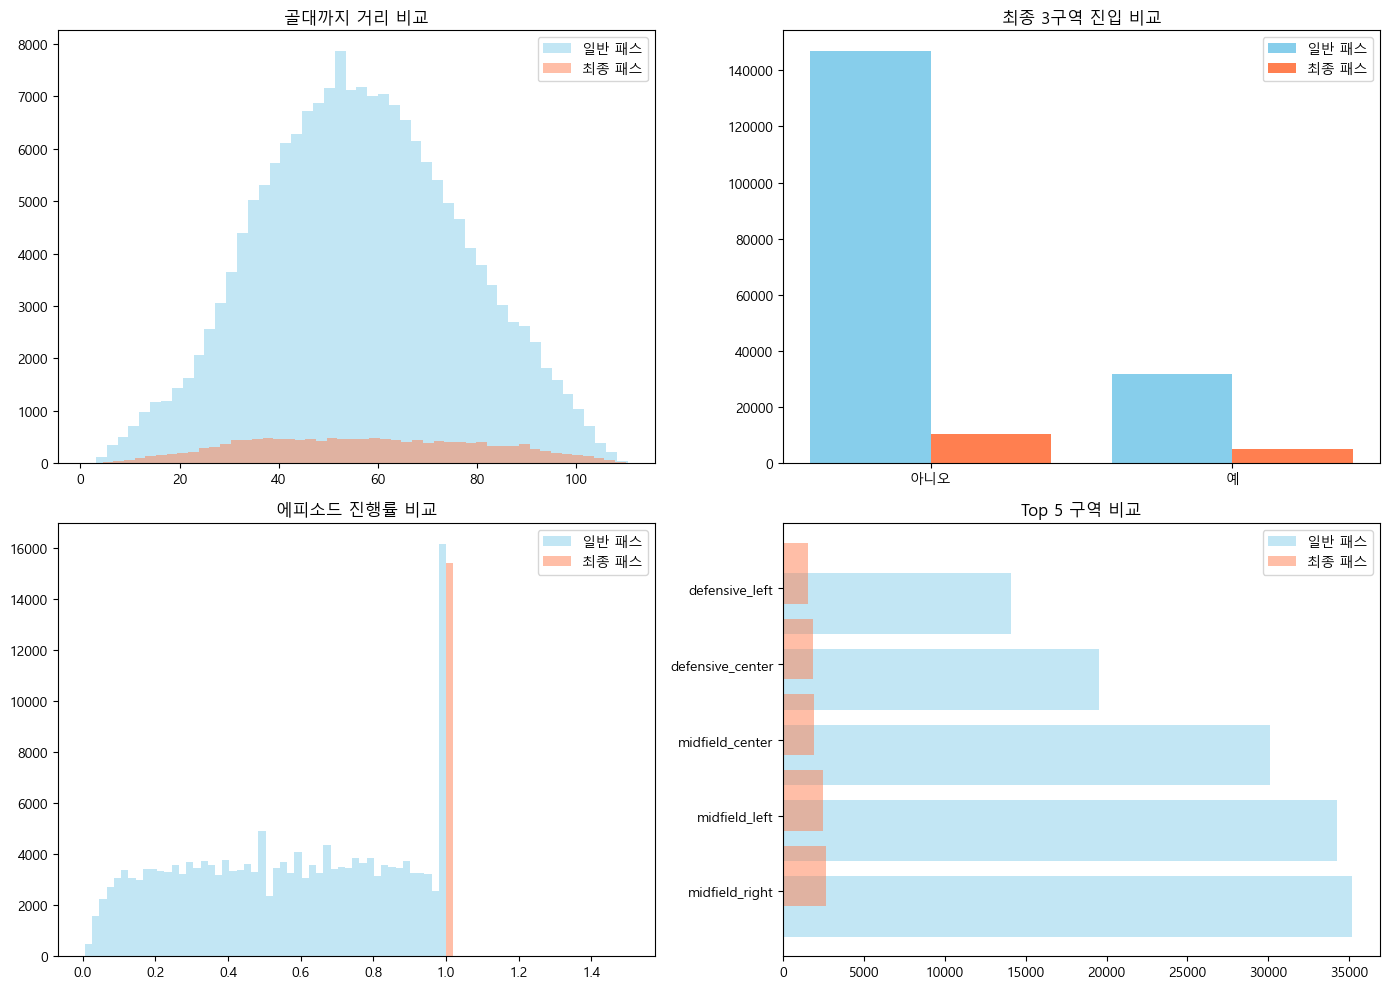

In [27]:
# 최종 패스 vs 일반 패스 비교
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# dist_to_target_goal 비교
axes[0, 0].hist(train_featured[train_featured['type_name']=='Pass']['dist_to_target_goal'], 
                bins=50, alpha=0.5, label='일반 패스', color='skyblue')
axes[0, 0].hist(last_passes['dist_to_target_goal'], 
                bins=50, alpha=0.5, label='최종 패스', color='coral')
axes[0, 0].set_title('골대까지 거리 비교')
axes[0, 0].legend()

# in_final_third 비교
final_third_regular = train_featured[train_featured['type_name']=='Pass']['in_final_third'].value_counts()
final_third_last = last_passes['in_final_third'].value_counts()
x = [0, 1]
axes[0, 1].bar([i-0.2 for i in x], final_third_regular, width=0.4, label='일반 패스', color='skyblue')
axes[0, 1].bar([i+0.2 for i in x], final_third_last, width=0.4, label='최종 패스', color='coral')
axes[0, 1].set_title('최종 3구역 진입 비교')
axes[0, 1].set_xticks([0, 1])
axes[0, 1].set_xticklabels(['아니오', '예'])
axes[0, 1].legend()

# episode_progress 비교
axes[1, 0].hist(train_featured[train_featured['type_name']=='Pass']['episode_progress'], 
                bins=50, alpha=0.5, label='일반 패스', color='skyblue')
axes[1, 0].hist(last_passes['episode_progress'], 
                bins=50, alpha=0.5, label='최종 패스', color='coral')
axes[1, 0].set_title('에피소드 진행률 비교')
axes[1, 0].legend()

# zone_combined 비교
zone_regular = train_featured[train_featured['type_name']=='Pass']['zone_combined'].value_counts().head(5)
zone_last = last_passes['zone_combined'].value_counts().head(5)
axes[1, 1].barh(range(5), zone_regular.values, alpha=0.5, label='일반 패스', color='skyblue')
axes[1, 1].barh([i+0.4 for i in range(5)], zone_last.values, alpha=0.5, label='최종 패스', color='coral')
axes[1, 1].set_yticks([i+0.2 for i in range(5)])
axes[1, 1].set_yticklabels(zone_regular.index)
axes[1, 1].set_title('Top 5 구역 비교')
axes[1, 1].legend()

plt.tight_layout()
plt.savefig('../reports/figures/feature_comparison_final_vs_regular.png', dpi=150)
plt.show()

## 10. 피처 저장

In [28]:
# 최종 패스만 저장 (모델 학습용)
print("💾 최종 패스 데이터 저장 중...")

# 필요한 컬럼 선택
feature_columns = [
    'game_episode', 'start_x', 'start_y', 'end_x', 'end_y',
    'dist_to_target_goal', 'zone_x', 'zone_y', 'zone_combined',
    'in_penalty_box', 'in_final_third', 'episode_progress'
]

last_passes = last_passes.reset_index()
last_passes_clean = last_passes[feature_columns].copy()

# 저장
output_path = PROCESSED_DIR / 'train_final_passes_featured.csv'
last_passes_clean.to_csv(output_path, index=True)  # game_episode가 인덱스

print(f"✅ 저장 완료: {output_path}")
print(f"데이터 크기: {last_passes_clean.shape}")
print(f"\n저장된 컬럼:")
for col in last_passes_clean.columns:
    print(f"  - {col}")

💾 최종 패스 데이터 저장 중...
✅ 저장 완료: ..\data\processed\train_final_passes_featured.csv
데이터 크기: (15435, 12)

저장된 컬럼:
  - game_episode
  - start_x
  - start_y
  - end_x
  - end_y
  - dist_to_target_goal
  - zone_x
  - zone_y
  - zone_combined
  - in_penalty_box
  - in_final_third
  - episode_progress


## 12. Phase 2: 시계열 피처 추가

In [29]:
print("="*60)
print("🚀 Phase 2 피처 생성 시작")
print("="*60)

# 피처 모듈 리로드
import importlib
sys.path.append('..')
from src.features import build_feature
importlib.reload(build_feature)
from src.features.build_feature import add_previous_action_features

🚀 Phase 2 피처 생성 시작


In [30]:
# 1. Pass 데이터만 필터링
print("\n📦 Step 1: Pass 데이터 필터링")
pass_data = train[train['type_name'] == 'Pass'].copy()
print(f"  - 전체 Pass: {len(pass_data):,}개")


📦 Step 1: Pass 데이터 필터링
  - 전체 Pass: 178,582개


In [31]:
# 2. Phase 1 피처 적용 (기존과 동일)
print("\n🔧 Step 2: Phase 1 피처 생성")
pass_featured = build_baseline_features(pass_data)
print(f"  - Phase 1 완료: {pass_featured.shape[1]}개 컬럼")



🔧 Step 2: Phase 1 피처 생성
  - Phase 1 완료: 24개 컬럼


In [32]:
# 3. Phase 2 피처 추가 (시계열)
print("\n🔧 Step 3: Phase 2 시계열 피처 생성")
pass_enhanced = add_previous_action_features(pass_featured)

# 새로 추가된 피처 확인
new_features = ['prev_end_x', 'prev_end_y', 'prev_action_distance', 
                'time_since_prev', 'prev_direction_x', 'prev_direction_y',
                'pass_count_in_episode']

print(f"  - Phase 2 완료: {pass_enhanced.shape[1]}개 컬럼")
print(f"\n  - 새로 추가된 시계열 피처 ({len(new_features)}개):")
for feat in new_features:
    if feat in pass_enhanced.columns:
        print(f"    ✓ {feat}")


🔧 Step 3: Phase 2 시계열 피처 생성
  - Phase 2 완료: 33개 컬럼

  - 새로 추가된 시계열 피처 (7개):
    ✓ prev_end_x
    ✓ prev_end_y
    ✓ prev_action_distance
    ✓ time_since_prev
    ✓ prev_direction_x
    ✓ prev_direction_y
    ✓ pass_count_in_episode


In [33]:
# 4. 시계열 피처 통계 확인
print("\n📊 Step 4: 시계열 피처 통계")
display(pass_enhanced[new_features].describe())


📊 Step 4: 시계열 피처 통계


,prev_end_x,prev_end_y,prev_action_distance,time_since_prev,prev_direction_x,prev_direction_y,pass_count_in_episode
count,178582.000000,178582.000000,178582.000000,178582.000000,178582.000000,178582.000000,178582.000000
mean,51.110918,34.044936,10.473155,3.438631,2.820777,-0.065895,12.295355
std,21.967737,20.122797,19.670279,4.742413,12.624235,13.263503,12.407637
min,0.000000,0.000000,0.000000,0.000000,-61.786063,-63.603868,1.000000
25%,35.626185,16.227741,0.000000,1.656000,-4.423703,-8.485057,4.000000
50%,50.618400,34.146778,2.746582,2.766000,1.036245,0.000000,8.000000
75%,67.226696,51.791860,8.375772,4.291000,8.589210,8.393427,17.000000
max,105.000000,68.000000,122.433361,655.822000,92.198222,63.981363,148.000000


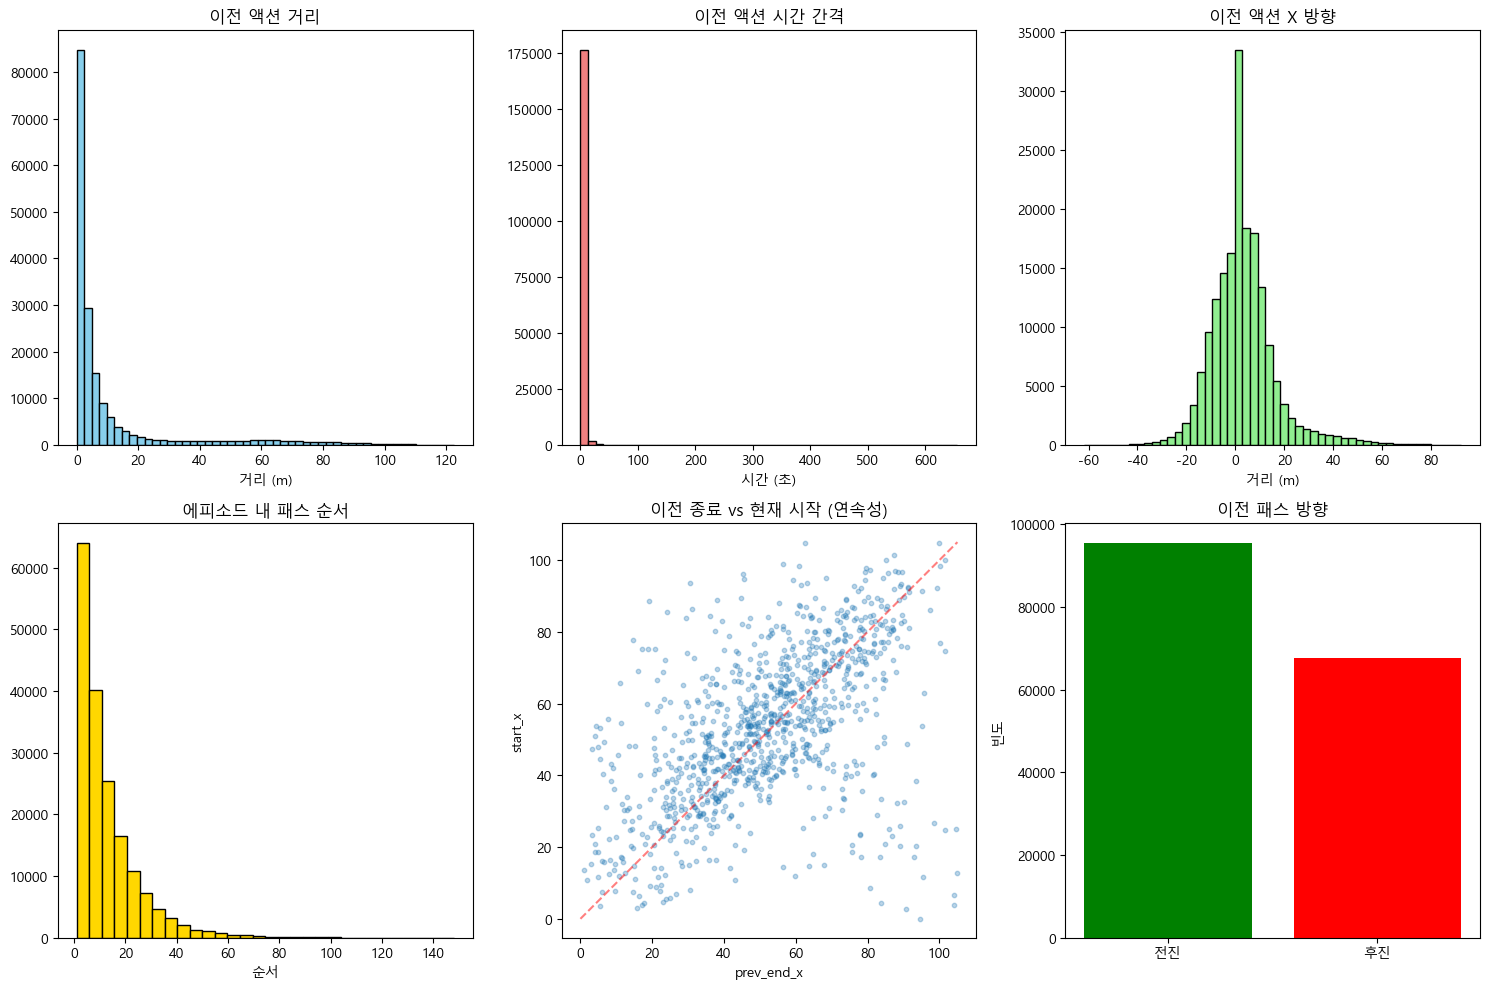

In [34]:
# 5. 시각화: 시계열 피처 분포
fig, axes = plt.subplots(2, 3, figsize=(15, 10))

# prev_action_distance
axes[0, 0].hist(pass_enhanced['prev_action_distance'], bins=50, color='skyblue', edgecolor='black')
axes[0, 0].set_title('이전 액션 거리')
axes[0, 0].set_xlabel('거리 (m)')

# time_since_prev
axes[0, 1].hist(pass_enhanced['time_since_prev'], bins=50, color='lightcoral', edgecolor='black')
axes[0, 1].set_title('이전 액션 시간 간격')
axes[0, 1].set_xlabel('시간 (초)')

# prev_direction_x
axes[0, 2].hist(pass_enhanced['prev_direction_x'], bins=50, color='lightgreen', edgecolor='black')
axes[0, 2].set_title('이전 액션 X 방향')
axes[0, 2].set_xlabel('거리 (m)')

# pass_count_in_episode
axes[1, 0].hist(pass_enhanced['pass_count_in_episode'], bins=30, color='gold', edgecolor='black')
axes[1, 0].set_title('에피소드 내 패스 순서')
axes[1, 0].set_xlabel('순서')

# prev_end_x vs end_x (연속성 확인)
sample = pass_enhanced.sample(1000)
axes[1, 1].scatter(sample['prev_end_x'], sample['end_x'], alpha=0.3, s=10)
axes[1, 1].plot([0, 105], [0, 105], 'r--', alpha=0.5)
axes[1, 1].set_title('이전 종료 vs 현재 시작 (연속성)')
axes[1, 1].set_xlabel('prev_end_x')
axes[1, 1].set_ylabel('start_x')

# prev_direction_x 분포 (전진/후진)
forward = pass_enhanced[pass_enhanced['prev_direction_x'] > 0]
backward = pass_enhanced[pass_enhanced['prev_direction_x'] < 0]
axes[1, 2].bar(['전진', '후진'], [len(forward), len(backward)], color=['green', 'red'])
axes[1, 2].set_title('이전 패스 방향')
axes[1, 2].set_ylabel('빈도')

plt.tight_layout()
plt.savefig('../reports/figures/phase2_temporal_features.png', dpi=150)
plt.show()

In [35]:
# 6. 최종 패스만 추출
print("\n📌 Step 5: 최종 패스 추출")
final_passes_v2 = pass_enhanced.groupby('game_episode').last().reset_index()
print(f"  - 최종 패스: {len(final_passes_v2):,}개")


📌 Step 5: 최종 패스 추출
  - 최종 패스: 15,435개


In [36]:
# 7. 저장
print("\n💾 Step 6: 데이터 저장")

# 저장할 컬럼 정의
save_columns = [
    'game_episode', 'game_id', 'time_seconds',
    # 기본 정보
    'start_x', 'start_y', 'end_x', 'end_y',
    # Phase 1 피처
    'dist_to_target_goal', 'zone_x', 'zone_y', 'zone_combined',
    'in_penalty_box', 'in_final_third',
    # Phase 2 피처 (시계열)
    'prev_end_x', 'prev_end_y', 'prev_action_distance',
    'time_since_prev', 'prev_direction_x', 'prev_direction_y',
    'pass_count_in_episode'
]

final_passes_v2_clean = final_passes_v2[save_columns].copy()

# v2 파일로 저장
output_path = PROCESSED_DIR / 'train_final_passes_v2.csv'
final_passes_v2_clean.to_csv(output_path, index=False)

print(f"✅ 저장 완료: {output_path}")
print(f"  - 데이터 크기: {final_passes_v2_clean.shape}")
print(f"  - Phase 1 피처: 8개")
print(f"  - Phase 2 피처: 7개")
print(f"  - 총 피처: 15개 (기본 정보 제외)")

print("\n" + "="*60)
print("🎊 Phase 2 피처 생성 완료!")
print("="*60)



💾 Step 6: 데이터 저장


'\noutput_path = PROCESSED_DIR / \'train_final_passes_v2.csv\'\nfinal_passes_v2_clean.to_csv(output_path, index=False)\n\nprint(f"✅ 저장 완료: {output_path}")\nprint(f"  - 데이터 크기: {final_passes_v2_clean.shape}")\nprint(f"  - Phase 1 피처: 8개")\nprint(f"  - Phase 2 피처: 7개")\nprint(f"  - 총 피처: 15개 (기본 정보 제외)")\n\nprint("\n" + "="*60)\nprint("🎊 Phase 2 피처 생성 완료!")\nprint("="*60)\n'

 ## 13. Phase 3: 고급 시계열 피처 생성

In [37]:
print("="*60)
print("🚀 Phase 3 피처 생성 시작")
print("="*60)

# 피처 모듈 리로드
import importlib
sys.path.append('..')
from src.features import advanced_features
importlib.reload(advanced_features)
from src.features.advanced_features import build_phase3_features

🚀 Phase 3 피처 생성 시작


In [38]:
# 1. 전체 Pass 데이터 로드 (Phase 2까지 완료된 데이터)
print("\n📂 Phase 2 데이터 로딩...")

# Phase 2 데이터가 이미 있다면
if 'pass_enhanced' in locals():
    print("  - 기존 데이터 사용 (메모리)")
    pass_data = pass_enhanced.copy()
else:
    # 또는 파일에서 로드
    pass_v2_path = PROCESSED_DIR / 'train_passes_enhanced_v2.csv'
    if pass_v2_path.exists():
        print(f"  - 파일 로드: {pass_v2_path}")
        pass_data = pd.read_csv(pass_v2_path)
    else:
        print("  ⚠️ Phase 2 데이터 없음! 새로 생성...")
        # Pass 데이터 필터링
        pass_data = train[train['type_name'] == 'Pass'].copy()
        
        # Phase 1 피처
        pass_data = build_baseline_features(pass_data)
        
        # Phase 2 피처
        pass_data = add_previous_action_features(pass_data)

print(f"  ✅ 데이터 로드 완료: {pass_data.shape}")


📂 Phase 2 데이터 로딩...
  - 기존 데이터 사용 (메모리)
  ✅ 데이터 로드 완료: (178582, 33)


In [39]:
# 2. Phase 3 피처 생성
print("\n🔧 Phase 3 피처 생성 중...")
print(f"  - 입력 컬럼 수: {len(pass_data.columns)}")

pass_phase3 = build_phase3_features(pass_data)

print(f"  ✅ Phase 3 완료!")
print(f"  - 출력 컬럼 수: {len(pass_phase3.columns)}")
print(f"  - 추가된 피처: {len(pass_phase3.columns) - len(pass_data.columns)}개")


🔧 Phase 3 피처 생성 중...
  - 입력 컬럼 수: 33
🔧 Phase 3 피처 생성 중...
  - 롤링 통계...
     롤링 통계 end
  - 누적 통계...
     누적 통계 end
  - 속도 분석...
     속도 분석 end
  - 공간 활용...
     공간 활용 end
  - 패턴 인식...
     패턴 인식 end
✅ Phase 3 완료!
  ✅ Phase 3 완료!
  - 출력 컬럼 수: 56
  - 추가된 피처: 23개


In [40]:
# 3. 새로 추가된 피처 확인
new_features = [col for col in pass_phase3.columns if col not in pass_data.columns]

print(f"\n📊 새로 생성된 피처 ({len(new_features)}개):")
for i, feat in enumerate(new_features, 1):
    print(f"  {i:2d}. {feat}")


📊 새로 생성된 피처 (23개):
   1. rolling_mean_distance_3
   2. rolling_std_distance_3
   3. rolling_mean_direction_x_3
   4. rolling_mean_direction_y_3
   5. rolling_mean_distance_5
   6. rolling_std_distance_5
   7. rolling_mean_direction_x_5
   8. rolling_mean_direction_y_5
   9. cumulative_distance
  10. cumulative_forward
  11. cumulative_lateral
  12. forward_lateral_ratio
  13. pass_velocity
  14. avg_episode_velocity
  15. velocity_change
  16. recent_3_avg_velocity
  17. episode_x_range
  18. episode_y_range
  19. touchline_proximity
  20. avg_touchline_proximity
  21. is_buildup
  22. is_counter
  23. is_under_pressure


In [41]:
# 4. 피처 통계 확인
print(f"\n📈 새 피처 기본 통계:")

# 대표 피처 몇 개 선택
sample_features = [
    'rolling_mean_distance_3',
    'cumulative_distance',
    'pass_velocity',
    'episode_x_range',
    'is_buildup'
]

available_features = [f for f in sample_features if f in pass_phase3.columns]
display(pass_phase3[available_features].describe())


📈 새 피처 기본 통계:


,rolling_mean_distance_3,cumulative_distance,pass_velocity,episode_x_range,is_buildup
count,178582.000000,178582.000000,178582.000000,178582.000000,178582.000000
mean,9.583473,124.238487,2.926776,43.530895,0.831825
std,11.858254,151.649222,8.254058,27.744186,0.374023
min,0.000000,0.000000,0.000000,0.000000,0.000000
25%,1.696031,13.903113,0.000000,19.482540,1.000000
50%,4.349662,73.356103,0.877110,44.430960,1.000000
75%,13.613884,179.600612,1.940845,67.081665,1.000000
max,104.018543,1865.471308,853.464940,104.042345,1.000000


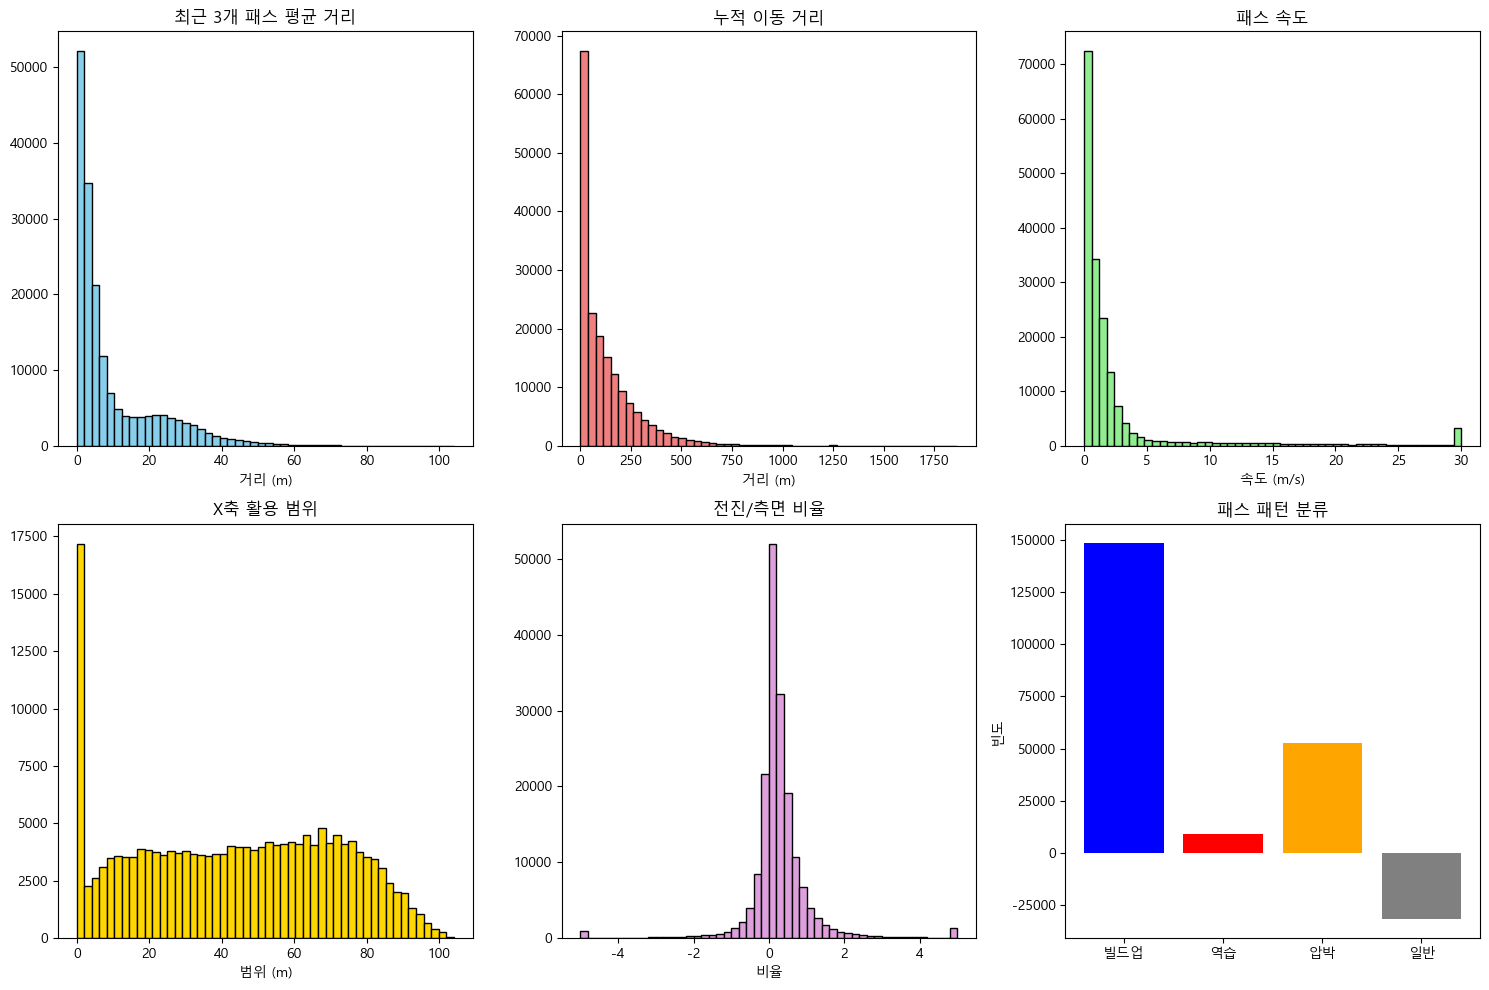

In [42]:
# 5. 시각화: 새 피처 분포
fig, axes = plt.subplots(2, 3, figsize=(15, 10))

if 'rolling_mean_distance_3' in pass_phase3.columns:
    axes[0, 0].hist(pass_phase3['rolling_mean_distance_3'].dropna(), bins=50, color='skyblue', edgecolor='black')
    axes[0, 0].set_title('최근 3개 패스 평균 거리')
    axes[0, 0].set_xlabel('거리 (m)')

if 'cumulative_distance' in pass_phase3.columns:
    axes[0, 1].hist(pass_phase3['cumulative_distance'].dropna(), bins=50, color='lightcoral', edgecolor='black')
    axes[0, 1].set_title('누적 이동 거리')
    axes[0, 1].set_xlabel('거리 (m)')

if 'pass_velocity' in pass_phase3.columns:
    axes[0, 2].hist(pass_phase3['pass_velocity'].dropna().clip(0, 30), bins=50, color='lightgreen', edgecolor='black')
    axes[0, 2].set_title('패스 속도')
    axes[0, 2].set_xlabel('속도 (m/s)')

if 'episode_x_range' in pass_phase3.columns:
    axes[1, 0].hist(pass_phase3['episode_x_range'].dropna(), bins=50, color='gold', edgecolor='black')
    axes[1, 0].set_title('X축 활용 범위')
    axes[1, 0].set_xlabel('범위 (m)')

if 'forward_lateral_ratio' in pass_phase3.columns:
    axes[1, 1].hist(pass_phase3['forward_lateral_ratio'].dropna().clip(-5, 5), bins=50, color='plum', edgecolor='black')
    axes[1, 1].set_title('전진/측면 비율')
    axes[1, 1].set_xlabel('비율')

# 패턴 분포
if all(col in pass_phase3.columns for col in ['is_buildup', 'is_counter', 'is_under_pressure']):
    pattern_counts = pd.Series({
        '빌드업': pass_phase3['is_buildup'].sum(),
        '역습': pass_phase3['is_counter'].sum(),
        '압박': pass_phase3['is_under_pressure'].sum(),
        '일반': len(pass_phase3) - pass_phase3[['is_buildup', 'is_counter', 'is_under_pressure']].sum().sum()
    })
    axes[1, 2].bar(pattern_counts.index, pattern_counts.values, color=['blue', 'red', 'orange', 'gray'])
    axes[1, 2].set_title('패스 패턴 분류')
    axes[1, 2].set_ylabel('빈도')

plt.tight_layout()
plt.savefig('../reports/figures/phase3_features_distribution.png', dpi=150)
plt.show()

In [43]:
# 6. 최종 패스만 추출
print("\n📌 최종 패스 추출 중...")

final_passes_v3 = pass_phase3.groupby('game_episode').last().reset_index()

print(f"  ✅ 최종 패스: {len(final_passes_v3):,}개")
print(f"  - 컬럼 수: {len(final_passes_v3.columns)}")


📌 최종 패스 추출 중...
  ✅ 최종 패스: 15,435개
  - 컬럼 수: 56


In [44]:
# 7. 저장할 컬럼 선택
print("\n💾 저장 준비 중...")

# 기본 정보
base_columns = ['game_episode', 'game_id', 'time_seconds', 'start_x', 'start_y', 'end_x', 'end_y']

# Phase 1 피처
phase1_columns = [
    'dist_to_target_goal', 'zone_x', 'zone_y', 'zone_combined',
    'in_penalty_box', 'in_final_third'
]

# Phase 2 피처
phase2_columns = [
    'prev_end_x', 'prev_end_y', 'prev_action_distance',
    'time_since_prev', 'prev_direction_x', 'prev_direction_y',
    'pass_count_in_episode'
]

# Phase 3 피처 (새로 생성된 것들)
phase3_columns = new_features

# 전체 컬럼 (존재하는 것만)
all_columns = []
for col_list in [base_columns, phase1_columns, phase2_columns, phase3_columns]:
    for col in col_list:
        if col in final_passes_v3.columns:
            all_columns.append(col)

print(f"  - 저장할 컬럼: {len(all_columns)}개")
print(f"    - 기본: {len([c for c in base_columns if c in all_columns])}")
print(f"    - Phase 1: {len([c for c in phase1_columns if c in all_columns])}")
print(f"    - Phase 2: {len([c for c in phase2_columns if c in all_columns])}")
print(f"    - Phase 3: {len([c for c in phase3_columns if c in all_columns])}")


💾 저장 준비 중...
  - 저장할 컬럼: 43개
    - 기본: 7
    - Phase 1: 6
    - Phase 2: 7
    - Phase 3: 23


In [45]:
# 8. 최종 저장
final_passes_v3_clean = final_passes_v3[all_columns].copy()

# v3 파일로 저장
output_path = PROCESSED_DIR / 'train_final_passes_v3.csv'
final_passes_v3_clean.to_csv(output_path, index=False)

print(f"\n✅ 저장 완료: {output_path}")
print(f"  - 데이터 크기: {final_passes_v3_clean.shape}")
print(f"  - 파일 크기: {output_path.stat().st_size / 1024 / 1024:.2f} MB")


✅ 저장 완료: ..\data\processed\train_final_passes_v3.csv
  - 데이터 크기: (15435, 43)
  - 파일 크기: 8.06 MB


In [47]:
# 9. Phase별 피처 비교
print("\n📊 Phase별 피처 수 비교:")
print(f"  - Phase 1 (v1): 8개 피처 → CV 20.36m")
print(f"  - Phase 2 (v2): 15개 피처 → CV 18.88m")
print(f"  - Phase 3 (v3): {len(all_columns) - 7}개 피처 → CV ???")

print("\n" + "="*60)
print("🎊 Phase 3 데이터 생성 완료!")
print("="*60)


📊 Phase별 피처 수 비교:
  - Phase 1 (v1): 8개 피처 → CV 20.36m
  - Phase 2 (v2): 15개 피처 → CV 18.88m
  - Phase 3 (v3): 36개 피처 → CV ???

🎊 Phase 3 데이터 생성 완료!
